<a href="https://colab.research.google.com/github/AngelMaximiliano0/DolphinDetector/blob/main/DolphinDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Test Dolphin Detector

#Pre procesamiento de los datos
##### (1) Importe del dataset
##### (2) Visualización
##### (3) Conversor labels a formato requerido
##### (4) Organización del dataset = train; val; test

#### 1 Configuración de acceso

In [ ]:
# (1) Importe de dataset

from google.colab import drive
drive.mount('/content/drive') #Conecto GDrive

Mounted at /content/drive


In [ ]:
# Rutas de entrada
image_path = "/content/drive/MyDrive/Colab_Notebooks/Detector/images"
labels_path = "/content/drive/MyDrive/Colab_Notebooks/Detector/labels"

# Rutas de salida
output_path = "/content/drive/MyDrive/Colab_Notebooks/Detector"

#### Importe librerías

In [ ]:
#Librerías a usar
import matplotlib.pyplot as plt  #Permite generar gráficos y visualizarlos (la llamé plt)
import matplotlib.image as mpimg #Permite leer y manipular imagenes (la llamé mpimg)
import os                        #Interactua con el SO, construyendo las rutas de acceso
import json                      #Permite trabajar con archivos JSON
import matplotlib.patches as patches #Permite crear formas geométricas sobre la imagen
from PIL import Image            #Image desde PILLOW: Abre, manipula y guarda imágenes.


#### 2 Visualización

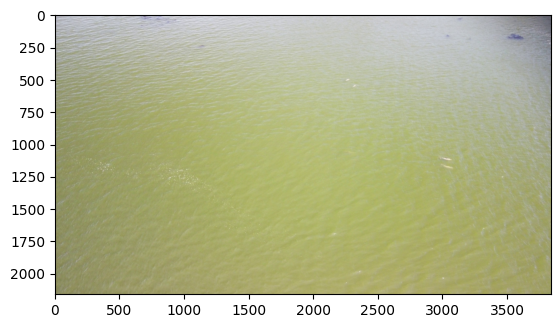

In [ ]:
# Crea la ruta completa a la imagen
ruta_imagen = os.path.join(image_path, "DJI_0019_029.jpg") #Permite definir ruta y buscar imágen

# Carga la imagen usando matplotlib.image.imread
imagen = mpimg.imread(ruta_imagen)

# Muestra la imagen usando matplotlib.pyplot.imshow
plt.imshow(imagen)
plt.axis('on')  # Muestra los ejes
plt.show()

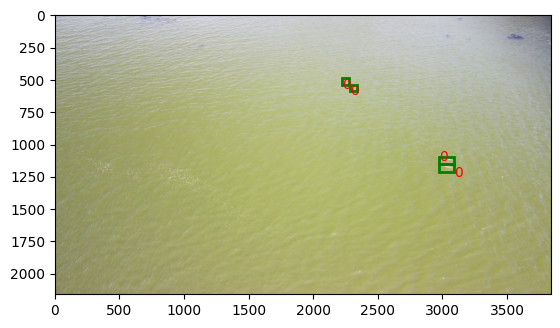

In [ ]:
#Visualización de imagen con respectivo BBOX

nombre_imagen = "DJI_0019_029.jpg" #La transformo en variable para ser usada en la función siguiente

# Crea la ruta completa a la imagen y al archivo JSON
ruta_imagen = os.path.join(image_path, nombre_imagen)
ruta_json = os.path.join(labels_path, nombre_imagen[:-4] + '.json')  # Asume que el archivo JSON tiene el mismo nombre que la imagen pero con extensión .json

imagen = Image.open(ruta_imagen) #Abre la imagen con PILL

# Carga el archivo JSON
with open(ruta_json, 'r') as f:  #Abre un JSON, lee (r). Usa with para cerrar el bloque. JSON -> f. Lo carga en una variable
    datos_json = json.load(f)     #Carga F en datos_json

# Crea una figura y un eje usando matplotlib
fig, ax = plt.subplots(1)  #fig controla aspectos de la figura. ax es la variable que se dibuja en el subplot (1)

# Muestra la imagen en el eje
ax.imshow(imagen)  #Muestra la imagen en el eje

# Dibuja los bounding boxes
for shapes in datos_json['shapes']:  #Recorre los shapes del JSON que contiene las características mencionadas, asignandolas a var
    points = shapes['points']
    label = shapes['label']

#Crear rectángulo
    x, y = points[0]  #Desempaqueta los valores x e y de points asignandolos
    width = points[1][0] - points[0][0] #define ancho del rectángulo en base a points
    height = points[1][1] - points[0][1]  #define el alto del rectángulo en base a points
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='g', facecolor='none')

#Agregar rectángulo y etiquetas al eje:
###El problema de no visualización de los rectángulos estaba dado porque dejé fuera del loop las funciones que siguen.
    ax.add_patch(rect)
    ax.text(x, y, label, color='r', fontsize=10, ha = "left", va = "center")

# Oculta los ejes
plt.axis('on')
# Muestra la imagen con los bounding boxes
plt.show()




#### 3 conversor formato labels y organización con paquete "labelme2yolo"

In [ ]:
# (2) Conversor de Formato
#!pip install labelme2yolo
#activación paquete
!labelme2yolo --json_dir "/content/drive/MyDrive/Colab_Notebooks/Detector/labels" --val_size 0.10 --test_size 0.10



## Clasificador de Imágenes basado en TF y Keras

In [ ]:
#Esto es un clasificador basado en redes neuronales convolucionales

# 1. Importa las bibliotecas necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# 2. Define la arquitectura de la CNN
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

# 3. Compila el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Carga y preprocesa tu conjunto de datos
# ... (código para cargar imágenes y etiquetas) ...

# 5. Entrena el modelo
model.fit(train_images, train_labels, epochs=10, batch_size=32)

# 6. Evalúa el modelo
loss, accuracy = model.evaluate(test_images, test_labels)
print('Loss:', loss)
print('Accuracy:', accuracy)

# 7. Realiza predicciones
predictions = model.predict(new_images)

#Detector de objetos con YOLO

In [ ]:
import yaml

data = {
    'path': "/content/drive/MyDrive/Colab_Notebooks/YOLODataset",
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {
        0: 'dolphin'
    }
}

with open("/content/drive/MyDrive/Colab_Notebooks/YOLODataset/data.yaml", 'w') as file:
    yaml.dump(data, file,
              default_flow_style=False,
              sort_keys=False)

In [ ]:
!pip install ultralytics

In [ ]:

from ultralytics import YOLO

# Cargar el modelo (nano, el más pequeño)
model = YOLO("yolo11n.pt")

# Afinar el modelo con imágenes 4K
results = model.train(
    data= "/content/drive/MyDrive/Colab_Notebooks/YOLODataset/data.yaml",  # Configuración de datos
    epochs=100,               # Número de iteraciones
    imgsz=3840,              # Tamaño de entrada ajustado a la resolución 4K
    plots=True,              # Guardar gráficos de entrenamiento
    batch=1,                 # Reducir el tamaño del lote si el hardware es limitado
    workers=2,               # Control de procesos paralelos
    optimizer= "Adam"
)




Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/Colab_Notebooks/YOLODataset/data.yaml, epochs=100, time=None, patience=100, batch=1, imgsz=3840, save=True, save_period=-1, cache=False, device=None, workers=2, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

100%|██████████| 755k/755k [00:00<00:00, 20.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/.shortcut-targets-by-id/1EKaqX4bKz6WvLNqWAv13mfShOOkeutKp/YOLODataset/labels/train... 1041 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1041/1041 [06:50<00:00,  2.54it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1EKaqX4bKz6WvLNqWAv13mfShOOkeutKp/YOLODataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/.shortcut-targets-by-id/1EKaqX4bKz6WvLNqWAv13mfShOOkeutKp/YOLODataset/labels/val... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]

val: New cache created: /content/drive/.shortcut-targets-by-id/1EKaqX4bKz6WvLNqWAv13mfShOOkeutKp/YOLODataset/labels/val.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 3840 train, 3840 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      15.2G       2.48      3.403      2.504         63       3840: 100%|██████████| 1041/1041 [14:05<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

                   all        100        555      0.153      0.267     0.0977     0.0307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      13.1G      2.364      2.765      2.529          7       3840: 100%|██████████| 1041/1041 [12:25<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:13<00:00,  3.81it/s]

                   all        100        555      0.307      0.272        0.2     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.2G      2.347      2.606      2.503         16       3840: 100%|██████████| 1041/1041 [12:25<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


                   all        100        555      0.172      0.177     0.0863     0.0275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.2G      2.308      2.554      2.513          0       3840: 100%|██████████| 1041/1041 [12:26<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


                   all        100        555      0.254      0.265      0.178     0.0559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.1G      2.249      2.412      2.421         41       3840: 100%|██████████| 1041/1041 [12:17<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:15<00:00,  3.26it/s]

                   all        100        555      0.296      0.245      0.207     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.2G      2.255      2.489       2.43          2       3840: 100%|██████████| 1041/1041 [12:17<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:14<00:00,  3.52it/s]

                   all        100        555      0.232      0.205      0.117     0.0422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.1G      2.174       2.24      2.373          2       3840: 100%|██████████| 1041/1041 [12:02<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:14<00:00,  3.44it/s]

                   all        100        555      0.306      0.391      0.271     0.0895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.1G      2.198      2.208      2.413         20       3840: 100%|██████████| 1041/1041 [12:10<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:14<00:00,  3.34it/s]

                   all        100        555      0.302      0.243      0.195     0.0678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.1G      2.168      2.166      2.362          8       3840: 100%|██████████| 1041/1041 [11:58<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:13<00:00,  3.71it/s]

                   all        100        555      0.303      0.387      0.266     0.0949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.1G      2.145      2.127      2.378          5       3840: 100%|██████████| 1041/1041 [11:37<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:14<00:00,  3.51it/s]

                   all        100        555      0.361      0.391      0.327      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.2G      2.135      2.042      2.339         20       3840: 100%|██████████| 1041/1041 [11:48<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:13<00:00,  3.65it/s]

                   all        100        555      0.411      0.446      0.374      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.1G       2.08       2.02      2.305          5       3840: 100%|██████████| 1041/1041 [11:29<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:13<00:00,  3.58it/s]


                   all        100        555       0.37      0.306       0.23      0.083

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.1G      2.116      2.098      2.328         14       3840: 100%|██████████| 1041/1041 [11:39<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:14<00:00,  3.42it/s]

                   all        100        555      0.287      0.276      0.183     0.0656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.1G      2.097      2.013      2.323          2       3840: 100%|██████████| 1041/1041 [11:32<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:14<00:00,  3.47it/s]


                   all        100        555       0.39      0.301      0.273     0.0918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.1G      2.097      1.939      2.314          4       3840: 100%|██████████| 1041/1041 [11:47<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:15<00:00,  3.27it/s]

                   all        100        555      0.409      0.459      0.399      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      12.9G      2.051      1.892      2.284         53       3840: 100%|██████████| 1041/1041 [12:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


                   all        100        555      0.381      0.429      0.368      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.1G      2.025      1.862      2.254         13       3840: 100%|██████████| 1041/1041 [11:41<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:13<00:00,  3.68it/s]

                   all        100        555       0.43      0.432      0.411      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.1G      2.028      1.904       2.27         34       3840: 100%|██████████| 1041/1041 [11:36<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]

                   all        100        555      0.417      0.362      0.325      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.3G      2.059      1.881      2.253         18       3840: 100%|██████████| 1041/1041 [11:31<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:13<00:00,  3.81it/s]

                   all        100        555      0.462      0.483      0.452      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      13.1G      2.037      1.805      2.269          4       3840:  60%|██████    | 625/1041 [07:01<04:55,  1.41it/s]

In [ ]:
from IPython.display import Image as IPyImage
IPyImage(filename= "/content/runs/detect/train2/results.png")

In [ ]:
IPyImage(filename= "/content/runs/detect/train2/confusion_matrix.png", width=600)

In [ ]:
IPyImage(filename= "/content/runs/detect/train2/val_batch0_pred.jpg")

In [ ]:
#Montar modelo
from ultralytics import YOLO
model = YOLO("/content/drive/MyDrive/Colab_Notebooks/Detector/train1/best.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


##Predicciones. 50 imagenes de testeo

In [ ]:
#Predicción todas
preds = model('/content/drive/MyDrive/Colab_Notebooks/Detector/YOLODataset/images/test')

In [ ]:
#Mostrar uno
preds[1].show()